In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

# Using TF-IDF

$$
TF = \frac{{\text{{number of instances of a word in a document}}}}{{\text{{total number of words in a document}}}}
$$


$$
IDF = log \frac{{\text{{total number of documents (N) in text corpus D}}}}{{\text{{number of documents containg w}}}}
$$

In [13]:
df = pd.read_csv('Dataset/train.csv')

In [14]:
df

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


In [15]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df['author'])

In [16]:
np.unique(y)

array([0, 1, 2])

In [17]:
## This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values
x_train,x_val, y_train,y_val = train_test_split(df['text'],y,stratify=y,test_size=0.1,shuffle=True)

In [18]:
print(x_train.shape)
print(x_val.shape)

(17621,)
(1958,)


`CountVectorizer`, `TfidfVectorizer`, and `TfidfTransformer` are all tools commonly used in natural language processing (NLP) pipelines, but they serve slightly different purposes. Here's how they can be used together or standalone:

1. **CountVectorizer**:
   - Standalone: CountVectorizer is used to convert a collection of text documents into a matrix of token counts, where each row represents a document and each column represents a word, with each cell indicating the count of the corresponding word in the document.
   - Together: CountVectorizer can be used as the initial step in preprocessing text data, followed by using either `TfidfTransformer` or `TfidfVectorizer` to convert the count matrix into a TF-IDF (Term Frequency-Inverse Document Frequency) weighted representation.

2. **TfidfVectorizer**:
   - Standalone: TfidfVectorizer combines the functionality of CountVectorizer and TfidfTransformer into a single step. It first tokenizes the text and counts occurrences of each token like CountVectorizer, then it transforms the count matrix into a TF-IDF representation like TfidfTransformer.
   - Together: TfidfVectorizer can be used as a replacement for CountVectorizer and TfidfTransformer together, simplifying the preprocessing pipeline.

3. **TfidfTransformer**:
   - Standalone: TfidfTransformer is used to transform a count matrix (obtained from CountVectorizer or similar methods) into a TF-IDF representation. It weighs the importance of each word in the document relative to the entire corpus.
   - Together: TfidfTransformer is typically used after CountVectorizer to convert the count matrix into a TF-IDF representation.

In summary, here's how they can be used:
- **CountVectorizer**: Converts text into a count matrix.
- **TfidfVectorizer**: Combines CountVectorizer and TfidfTransformer into one step, producing a TF-IDF representation directly from raw text.
- **TfidfTransformer**: Converts a count matrix into a TF-IDF representation, typically used after CountVectorizer. 

You can choose to use them standalone or in combination based on the specific requirements and complexity of your NLP task. If you need a simple preprocessing pipeline, you can use `TfidfVectorizer`. If you need more control over the preprocessing steps, you can use `CountVectorizer` followed by `TfidfTransformer`.

In [19]:
tfb = TfidfVectorizer(min_df=3,max_features=None,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1,5),use_idf=True,smooth_idf=True,sublinear_tf=True,stop_words='english')

tfb.fit(list(x_train)+list(x_val))
x_train_tfb = tfb.transform(x_train)
x_val_tfb = tfb.transform(x_val)

In [20]:
def final_result(y_pred_prob,y_pred,x_val,y_val):
    print(y_val)
    mse_loss = mean_squared_error(y_pred,y_val)
    print(f'MSE loss: {mse_loss}')
    print(classification_report(y_val, y_pred, target_names=['0', '1','2']))
    table_submis = pd.DataFrame(y_pred_prob, columns=['EAP', 'MWS', 'HPL'])
    table_submis['id'] = df.loc[x_val.index,'id'].values
    table_submis = table_submis[['id','EAP','HPL','MWS']]

    result_df = pd.DataFrame({'Index': df.loc[x_val.index,'id'],'text':x_val, 'Predicted Label': lbl_enc.inverse_transform(y_pred), 'Actual Label': lbl_enc.inverse_transform(y_val)})
    return table_submis, result_df


In [21]:
### Logistic Regression

lg = LogisticRegression()
lg.fit(x_train_tfb,y_train)
y_pred = lg.predict(x_val_tfb)
y_pred_proba = lg.predict_proba(x_val_tfb)


/Users/anujjain/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
table_submis, result_df = final_result(y_pred_proba,y_pred,x_val,y_val)
print(table_submis)

[2 2 0 ... 0 2 1]
MSE loss: 0.4703779366700715
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       790
           1       0.83      0.76      0.79       564
           2       0.82      0.76      0.79       604

    accuracy                           0.80      1958
   macro avg       0.81      0.79      0.80      1958
weighted avg       0.80      0.80      0.80      1958

           id       EAP       HPL       MWS
0     id24239  0.020640  0.959664  0.019697
1     id22765  0.123976  0.845248  0.030777
2     id06298  0.767866  0.158755  0.073379
3     id10325  0.262326  0.036366  0.701308
4     id26532  0.752308  0.176806  0.070886
...       ...       ...       ...       ...
1953  id21175  0.921809  0.044164  0.034027
1954  id07913  0.452738  0.420180  0.127081
1955  id04754  0.546432  0.078788  0.374780
1956  id02574  0.841114  0.030806  0.128080
1957  id22770  0.194371  0.165192  0.640436

[1958 rows x 4 columns]


In [23]:
print(result_df)

         Index                                               text  \
5144   id24239  Adrian had the superiority in learning and elo...   
8125   id22765  Let me hear the sweet tones of your beloved vo...   
13261  id06298  They are all, however, fitting tapestry for a ...   
6631   id10325  Its two general directions, as I have said, we...   
584    id26532  After marriage, however, this gentleman neglec...   
...        ...                                                ...   
9712   id21175  But it has been suggested that the corpse disc...   
10254  id07913                              "How can I move thee?   
18562  id04754  "Moissart and Voissart" I repeated, thoughtful...   
18720  id02574                             Yet why do I say this?   
6467   id22770  So the White Ship sailed on past the walls of ...   

      Predicted Label Actual Label  
5144              MWS          MWS  
8125              MWS          MWS  
13261             EAP          EAP  
6631              HPL  

In [24]:


xb = xgb.XGBClassifier()

xb.fit(x_train_tfb,y_train)
y_pred_prob = xb.predict_proba(x_val_tfb)
y_pred = xb.predict(x_val_tfb)


In [25]:
table_submis, result_df = final_result(y_pred_proba,y_pred,x_val,y_val)
print(table_submis)


[2 2 0 ... 0 2 1]
MSE loss: 0.7563840653728294
              precision    recall  f1-score   support

           0       0.61      0.87      0.71       790
           1       0.75      0.56      0.64       564
           2       0.79      0.53      0.64       604

    accuracy                           0.68      1958
   macro avg       0.71      0.65      0.66      1958
weighted avg       0.70      0.68      0.67      1958

           id       EAP       HPL       MWS
0     id24239  0.020640  0.959664  0.019697
1     id22765  0.123976  0.845248  0.030777
2     id06298  0.767866  0.158755  0.073379
3     id10325  0.262326  0.036366  0.701308
4     id26532  0.752308  0.176806  0.070886
...       ...       ...       ...       ...
1953  id21175  0.921809  0.044164  0.034027
1954  id07913  0.452738  0.420180  0.127081
1955  id04754  0.546432  0.078788  0.374780
1956  id02574  0.841114  0.030806  0.128080
1957  id22770  0.194371  0.165192  0.640436

[1958 rows x 4 columns]


In [26]:

print(result_df)


         Index                                               text  \
5144   id24239  Adrian had the superiority in learning and elo...   
8125   id22765  Let me hear the sweet tones of your beloved vo...   
13261  id06298  They are all, however, fitting tapestry for a ...   
6631   id10325  Its two general directions, as I have said, we...   
584    id26532  After marriage, however, this gentleman neglec...   
...        ...                                                ...   
9712   id21175  But it has been suggested that the corpse disc...   
10254  id07913                              "How can I move thee?   
18562  id04754  "Moissart and Voissart" I repeated, thoughtful...   
18720  id02574                             Yet why do I say this?   
6467   id22770  So the White Ship sailed on past the walls of ...   

      Predicted Label Actual Label  
5144              MWS          MWS  
8125              MWS          MWS  
13261             EAP          EAP  
6631              HPL  

In [27]:
test = pd.read_csv('Dataset/test.csv')

In [28]:
### Unseen data
x_test = test['text']
x_test_tfb = tfb.transform(test['text'])


In [29]:
y_pred = lg.predict(x_test_tfb)
y_pred_proba = lg.predict_proba(x_test_tfb)

In [30]:
y_pred_proba.shape

(8392, 3)

In [31]:
def unseen_final_result(y_pred_prob,y_pred,x_test):
    table_submis = pd.DataFrame(y_pred_prob, columns=['EAP', 'MWS', 'HPL'])
    table_submis['id'] = test.loc[x_test.index,'id'].values
    table_submis = table_submis[['id','EAP','HPL','MWS']]

    result_df = pd.DataFrame({'Index': test.loc[x_test.index,'id'],'text':x_test, 'Predicted Label': lbl_enc.inverse_transform(y_pred)})

    return table_submis, result_df

In [32]:
table_submis, result_df = unseen_final_result(y_pred_proba,y_pred,x_test)

In [33]:
result_df

,Index,text,Predicted Label
0,id02310,"Still, as I urged our leaving Ireland with suc...",MWS
1,id24541,"If a fire wanted fanning, it could readily be ...",EAP
2,id00134,And when they had broken down the frail door t...,EAP
3,id27757,While I was thinking how I should possibly man...,EAP
4,id04081,I am not sure to what limit his knowledge may ...,EAP
...,...,...,...
8387,id11749,All this is now the fitter for my purpose.,MWS
8388,id10526,I fixed myself on a wide solitude.,MWS
8389,id13477,It is easily understood that what might improv...,EAP
8390,id13761,"Be this as it may, I now began to feel the ins...",MWS


# Bert Implementation

In [34]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd
import seaborn as sns
from collections import defaultdict
# Misc.
import warnings
warnings.filterwarnings('ignore')

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/anujjain/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
df = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [36]:
lbl_enc = LabelEncoder()
df['author_encoder'] = lbl_enc.fit_transform(df['author'])

In [37]:
df

,id,text,author,author_encoder
0,id26305,"This process, however, afforded me no means of...",EAP,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1
...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,0
19575,id08973,The lids clenched themselves together as if in...,EAP,0
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,0
19577,id17513,"For an item of news like this, it strikes us i...",EAP,0


In [38]:
Model = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(Model)
bert_model = BertModel.from_pretrained(Model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
token_lens=[]

for txt in df.text:
    tokens = tokenizer.encode(txt,max_length=512,truncation=True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

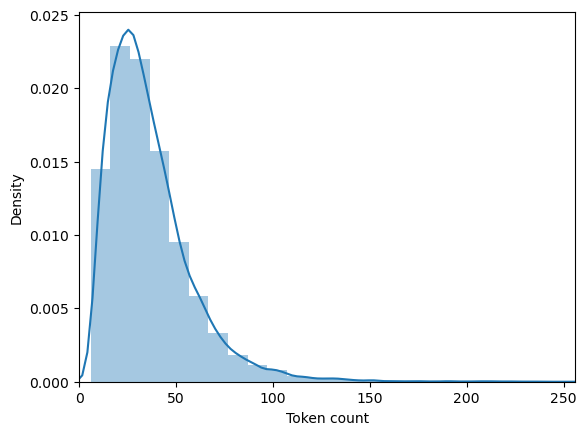

In [40]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [41]:

# Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.
MAX_LEN = 160


In [42]:
## Dataset
class auth_dataset(Dataset):
    def __init__(self,txt,authors,tokenizer,max_len):
        self.txt = txt
        self.authors = authors
        self.tokenizer = tokenizer
        self.max_len = max_len

    
    def __len__(self):
        return len(self.txt)
    
    def __getitem__(self,item):
        txt = str(self.txt[item])
        author = self.authors[item]

        encoding = self.tokenizer.encode_plus(
            txt,
            
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt',

        )
        return {
            'txt':txt,
            'input_id':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'authors': torch.tensor(author,dtype=torch.long)
        }



In [43]:
df_train,df_val = train_test_split(df,test_size=0.2,random_state=42)

In [44]:
### Create Dataloader

def create_dataloader(df, batch_size,max_len, num_workers,shuffle=True):
    ds = auth_dataset(
        txt = df.text.to_numpy(),
        authors=df.author_encoder.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
    )

In [45]:
BATCH_SIZE = 16
Num_workers = 0
train_data_loader = create_dataloader(df_train, BATCH_SIZE,MAX_LEN, Num_workers, shuffle=True)
val_data_loader = create_dataloader(df_val, BATCH_SIZE,MAX_LEN, Num_workers, shuffle=True)

In [46]:
data = next(iter(train_data_loader))
print(data.keys())

# print(data['txt'])
print(data['input_id'])
print(data['attention_mask'])
print(data['authors'])

dict_keys(['txt', 'input_id', 'attention_mask', 'authors'])
tensor([[  101,  1109, 13874,  ...,     0,     0,     0],
        [  101,  1124,  1108,  ...,     0,     0,     0],
        [  101, 13197,  1122,  ...,     0,     0,     0],
        ...,
        [  101, 25893,  1181,  ...,     0,     0,     0],
        [  101,   107, 10779,  ...,     0,     0,     0],
        [  101,  1109,  2915,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2])


In [47]:
### Sentiment Classifier
class SentimentClassifier(nn.Module):
    
    def __init__(self,n_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size,n_classes)
    
    def forward(self,input_ids,attention_mask):
        pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )[1] 

        output = self.drop(pooled_output)
        return self.out(output)
                           

In [48]:
unique_authors = df['author'].unique()
print(unique_authors)


model = SentimentClassifier(len(unique_authors))
model = model.to(device)

# Number of hidden units
print(bert_model.config.hidden_size)

['EAP' 'HPL' 'MWS']
768


In [49]:
Epoch=10
optim = AdamW(model.parameters(),lr=2e-5,correct_bias=False)

total_step = len(train_data_loader)*Epoch

scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps=0,
                                            num_training_steps=total_step)

loss_fn= nn.CrossEntropyLoss().to(device)

In [50]:
def train_epoch(model,data_loader,loss_fn,optim,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_pred =0

    for d in data_loader:
        input_ids = d["input_id"].to(device)
        attention_mask = d["attention_mask"].to(device)
        authors = d['authors'].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _,pred = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,authors)
        correct_pred += torch.sum(pred == authors)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optim.step()
        scheduler.step()
        optim.zero_grad() 
        

    return correct_pred.double()/n_examples, np.mean(losses)

In [51]:
def eval_model(model,data_loader, loss_fn,device,n_examples):
    model = model.eval()

    losses = []
    correct_pred = 0 

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_id"].to(device)
            attention_mask = d["attention_mask"].to(device)
            authors = d['authors'].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, authors)
            
            correct_pred += torch.sum(preds == authors)
            losses.append(loss.item())
    return correct_pred.double()/n_examples, np.mean(losses)


In [ ]:
best_accuracy = 0
history = defaultdict(list)
for epoch in range(Epoch):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{Epoch}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optim,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


In [ ]:
# Plot training and validation accuracy

# Extract scalar values from the tensors and convert to numpy arrays
train_acc_np = np.array([item.item() for item in history['train_acc']])
val_acc_np = np.array([item.item() for item in history['val_acc']])


plt.plot(train_acc_np, label='train accuracy')
plt.plot(val_acc_np, label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
### Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

def get_pred(model,data_loader):
    model = model.eval()

    txts =[]
    pred = []
    pred_prob = []
    real_val = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_id"].to(device)
            txt  = d["txt"]
            attention_mask = d["attention_mask"].to(device)
            authors = d['authors'].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)

            txts.extend(txt)
            pred.extend(preds)
            pred_prob.extend(outputs)
            real_val.extend(authors)

    pred = torch.stack(pred).cpu()
    pred_prob = torch.stack(pred_prob).cpu()
    real_val = torch.stack(real_val).cpu()

    return txts,pred,pred_prob,real_val

In [ ]:


y_review_texts, y_pred, y_pred_probs, y_test = get_pred(
    model,
    val_data_loader)



In [ ]:
y_pred_probs

In [ ]:
print(classification_report(y_test,y_pred,target_names=unique_authors))

In [ ]:


def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=unique_authors, columns=unique_authors)
show_confusion_matrix(df_cm)



In [ ]:
### Predict raw text
review_text = 'It never once occurred to me that the fumbling might be a mere mistake.'

In [ ]:
encoded_view = tokenizer.encode_plus(
    review_text,
    max_length = MAX_LEN,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt',
    truncation=True
)

In [ ]:
encoded_view

In [ ]:
input_ids = encoded_view['input_ids'].to(device)
attention_mask = encoded_view['attention_mask'].to(device)

output = model (input_ids,attention_mask)
_, pred = torch.max(output,dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {unique_authors[pred]}')

### Running Bert on Infernce Dataset

In [ ]:
class unseen_auth_dataset(Dataset):
    def __init__(self, txt, id, tokenizer, max_len):
        self.txt = txt
        self.id = id
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.txt)

    def __getitem__(self, item):
        txt = str(self.txt[item])
        id_ = self.id[item]

        encoding = self.tokenizer.encode_plus(
            txt,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt',
        )
        return {
            'id': id_,
            'txt': txt,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

In [ ]:
def create_unseen_dataloader(df, batch_size, max_len, num_workers, shuffle=True):
    ds = unseen_auth_dataset(
        txt=df.text.to_numpy(),
        id=df.id.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
    )


In [ ]:
unseen_dataset = create_unseen_dataloader(test, BATCH_SIZE, MAX_LEN, Num_workers, shuffle=True)


In [ ]:
data_ = next(iter(unseen_dataset))
data_.keys()

In [ ]:
def unseen_data_get_pred(model,data_loader):

    model = model.eval()
    ids = []
    txts =[]
    pred = []
    pred_prob = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            txt  = d["txt"]
            id = d["id"]
            attention_mask = d["attention_mask"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)

            ids.extend(id)
            txts.extend(txt)
            pred.extend(preds)
            pred_prob.extend(outputs)
            

    pred = torch.stack(pred).cpu()
    pred_prob = torch.stack(pred_prob).cpu()

    return txts,pred,pred_prob,ids

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_ids = unseen_data_get_pred(
    model,
    unseen_dataset)

In [142]:
data_dict = {
    'id': y_ids,
    'EAP': y_pred_probs[:, 0],  # Assuming the first column corresponds to class 'EAP'
    'HPL': y_pred_probs[:, 1],  # Assuming the second column corresponds to class 'HPL'
    'MWS': y_pred_probs[:, 2]   # Assuming the third column corresponds to class 'MWS'
}

# Create DataFrame
df = pd.DataFrame(data_dict)

# Display the DataFrame
print(df)

           id       EAP       HPL       MWS
0     id06617  8.333536 -3.732450 -3.290669
1     id22789 -4.320556 -4.206328  8.130929
2     id15726 -4.315736 -4.263460  8.090265
3     id19077 -4.007131  8.218512 -3.625121
4     id27537  8.471301 -4.089209 -3.262084
...       ...       ...       ...       ...
8387  id00335  8.347522 -4.157529 -2.928862
8388  id07054 -4.042836 -4.528657  7.536205
8389  id19578  8.526666 -3.780602 -3.477422
8390  id22422  8.453132 -3.574438 -3.551195
8391  id15215 -4.006074  8.351609 -3.855753

[8392 rows x 4 columns]


In [144]:
df.to_csv('submission.csv')